In [63]:
import warnings

warnings.filterwarnings("ignore")

### Carregamento dos Dados não Tratados

In [64]:
import pandas as pd

df = pd.read_csv('../../data/creditcard.csv')

class_label = df['Class']

In [65]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df['NormalizedAmount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df = df.drop(columns=['Class', 'Time', 'Amount'])

In [66]:
df.shape
df[df.duplicated()].shape
df.dropna(inplace=True)
df = df.drop_duplicates()

### Escolha do número de Cluster

In [67]:
from sklearn.cluster import KMeans
from tqdm import tqdm

k_range = range(1, 22)

inertias = []

for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)
    inertias.append(kmeans.inertia_)

100%|██████████| 21/21 [00:06<00:00,  3.11it/s]


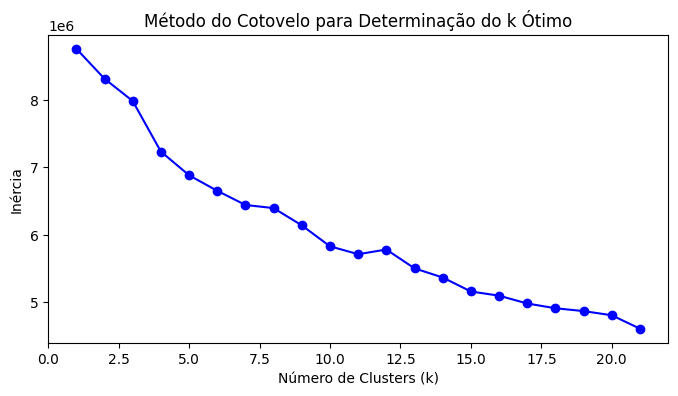

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo para Determinação do k Ótimo')
plt.show()

Vamos utilizar um cálculo para podermos encontrar o valor ótimo do número de clusters. Esse cálculo pode ser encontrado nesse blog [https://medium.com/pizzadedados/kmeans-e-metodo-do-cotovelo-94ded9fdf3a9].

In [69]:
from math import sqrt

def optimal_number_of_clusters(wcss):
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances

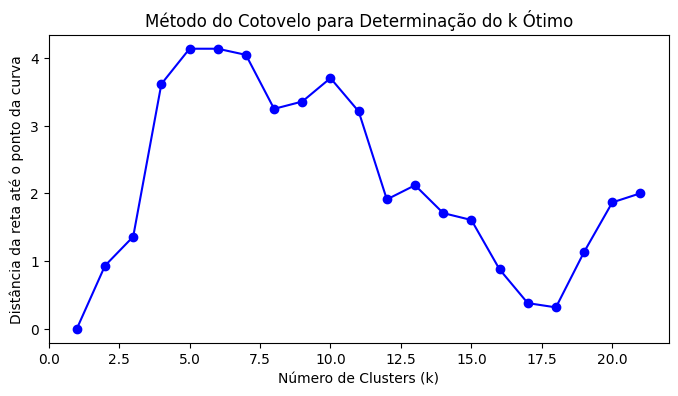

In [70]:
distances = optimal_number_of_clusters(inertias)

plt.figure(figsize=(8, 4))
plt.plot(k_range, distances, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Distância da reta até o ponto da curva')
plt.title('Método do Cotovelo para Determinação do k Ótimo')
plt.show()

In [71]:
print(distances.index(max(distances)) + 1)

5


Vemos que o número ideal de cluster, que possui o maior valor de distância entre a linha e o ponto na curva, é 3. Então podemos trabalhar com 3 clusters para os dados não tratados. Vamos adotar 42 como uma random seed padrão nesse projeto.

In [72]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(df)

KMeans(n_clusters=5, random_state=42)

Com base nos clusters encontrados usamos o "fit_predict" para que o kmeans classifique cada um dos dados dentro do nosso dataframe dentro dos  clusters encontrados

In [73]:
label = kmeans.fit_predict(df)

print("Clusters encontrados",label)
# Aparentemente foi encontrado o cluster 0 como sendo valores grandes, o cluster 1 sendo valores próximos de 0 e o cluster 2 negativos
print(df[label == 2])

Clusters encontrados [2 3 2 ... 0 2 2]
              V1        V2        V3        V4        V5        V6        V7  \
0      -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
2      -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3      -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4      -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   
5      -0.425966  0.960523  1.141109 -0.168252  0.420987 -0.029728  0.476201   
...          ...       ...       ...       ...       ...       ...       ...   
284798  0.219529  0.881246 -0.635891  0.960928 -0.152971 -1.014307  0.427126   
284801  0.120316  0.931005 -0.546012 -0.745097  1.130314 -0.235973  0.812722   
284803 -0.732789 -0.055080  2.035030 -0.738589  0.868229  1.058415  0.024330   
284805 -0.240440  0.530483  0.702510  0.689799 -0.377961  0.623708 -0.686180   
284806 -0.533413 -0.189733  0.703337 -0.506271 -0.012546 -0.649617  1.577006   



E olha só, ao realizar a visualização do nosso dataset clusterizado, podemos perceber claramente outliers, pois o eixo y está sendo montado com base no PCA, enquanto o x com base no Time, no entanto valores do Time se encontram nos mesmos clusters que dentro do PCA, gerando pontos fora da curva!

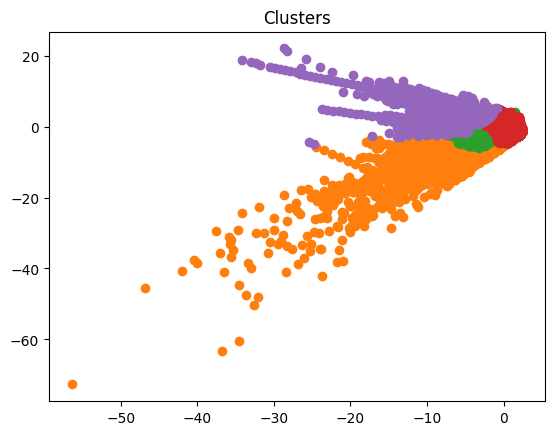

<Figure size 1200x1200 with 0 Axes>

In [74]:
import numpy as np

all_labels = np.unique(label)

for i in all_labels:
    plt.scatter(df[label == i].iloc[:, 0], df[label == i].iloc[:, 1], label=f'Cluster {i}')

plt.title("Clusters")
plt.figure(figsize=(12,12))
plt.show()

In [75]:
# Obter os centróides do melhor modelo
centroids = kmeans.cluster_centers_

# Converter os centróides para um DataFrame
centroids_df = pd.DataFrame(centroids, columns=df.columns)

# Salvar os centróides em um arquivo CSV
centroids_df.to_csv('../../data/best_centroids.csv', index=False)

In [76]:
df['cluster'] = kmeans.labels_
df['Class'] = class_label

df.to_csv('../../data/creditcard_clusters.csv', index=False)

### Carregamento dos Dados Tratados

In [77]:
df = pd.read_csv('../../data/creditcard_treated.csv')

class_label = df['Class']
df = df.drop(columns=['Class', 'Time', 'Amount'])



In [78]:
df.shape

(566506, 28)

### Escolha do número de Cluster do DF tratado

In [79]:
k_range = range(1, 22)

inertias = []

for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)
    inertias.append(kmeans.inertia_)

100%|██████████| 21/21 [00:13<00:00,  1.56it/s]


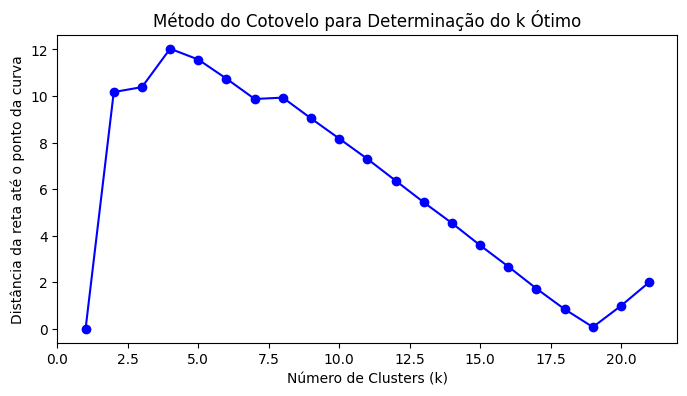

In [80]:
distances = optimal_number_of_clusters(inertias)

plt.figure(figsize=(8, 4))
plt.plot(k_range, distances, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Distância da reta até o ponto da curva')
plt.title('Método do Cotovelo para Determinação do k Ótimo')
plt.show()

O número se alterou para 4 agora...

In [81]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(df)

KMeans(n_clusters=4, random_state=42)

A inércia está muito mais alta em comparação, o que parece fazer sentido como o volume dos dados dobrou por causa do SMOTE.

In [82]:
label = kmeans.fit_predict(df)

print("Clusters encontrados",label)
#Aparentemente foi encontrado o cluster 0 como sendo valores grandes, o cluster 1 sendo valores próximos de 0 e o cluster 2 negativos
print(df[label == 1])

Clusters encontrados [0 0 0 ... 3 3 3]
               V1         V2         V3        V4         V5        V6  \
14117  -15.903635  10.393917 -19.133602  6.185969 -12.538021 -4.027030   
14144  -16.598665  10.541751 -19.818982  6.017295 -13.025901 -4.128779   
14158  -17.275191  10.819665 -20.363886  6.046612 -13.465033 -4.166647   
14867  -17.950631  11.067069 -20.742660  6.075531 -13.389765 -4.532888   
15113  -18.474868  11.586381 -21.402917  6.038515 -14.451158 -4.146524   
...           ...        ...        ...       ...        ...       ...   
566361 -24.521469  14.016292 -26.223297  6.317112 -18.179851 -4.606128   
566403 -25.453233  14.400303 -26.974312  6.357304 -18.785813 -4.657742   
566430 -23.084990  13.424442 -25.065545  6.255123 -17.245809 -4.526482   
566437 -24.559174  14.031763 -26.253658  6.318749 -18.204308 -4.608246   
566466 -22.624449  13.234746 -24.694388  6.235242 -16.946402 -4.500923   

               V7         V8        V9       V10  ...       V19       V2

Podemos perceber pelos gráficos agora com SMOTE que a classificação dos clusters não alterou absurdamente

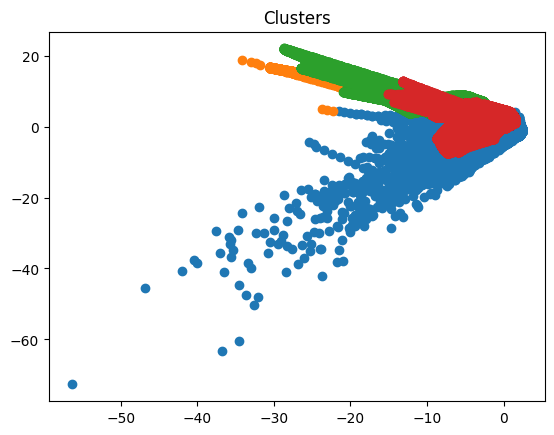

<Figure size 1200x1200 with 0 Axes>

In [83]:
all_labels = np.unique(label)

for i in all_labels:
    plt.scatter(df[label == i].iloc[:, 0], df[label == i].iloc[:, 1], label=f'Cluster {i}')

plt.title("Clusters")
plt.figure(figsize=(12,12))
plt.show()

In [84]:
# Obter os centróides do melhor modelo
centroids = kmeans.cluster_centers_

# Converter os centróides para um DataFrame
centroids_df = pd.DataFrame(centroids, columns=df.columns)

# Salvar os centróides em um arquivo CSV
centroids_df.to_csv('../../data/best_centroids_df_treated.csv', index=False)

In [85]:
df['cluster'] = kmeans.labels_
df['Class'] = class_label

df.to_csv('../../data/creditcard_treated_clusters.csv', index=False)